In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
import cv2
from cxlayers import AngularSpectrum, ImageResizing, InputToCx, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer

tf.experimental.numpy.experimental_enable_numpy_behavior()

plt.rcParams["font.size"]=18

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [3]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [9]:
shape = (100, 100)

inputs = tf.keras.Input((100, 100))
# x = ImageResizing(shape)(inputs)
# x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = InputToCx(shape)(inputs)
x = CxMO(shape)(x)
x = AngularSpectrum(shape, 531e-9, 0.1e-3, d=1.0e-6, method='band_limited')(x)
x = CxD2NNIntensity(shape)(x)
model = tf.keras.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100)]        0         
                                                                 
 input_to_cx_1 (InputToCx)   (None, 2, 2, 100, 100)    0         
                                                                 
 cx_mo_1 (CxMO)              (None, 2, 2, 100, 100)    10000     
                                                                 
 angular_spectrum (AngularSp  (None, 2, 2, 100, 100)   0         
 ectrum)                                                         
                                                                 
 cx_d2nn_intensity (CxD2NNIn  (None, 100, 100)         0         
 tensity)                                                        
                                                                 
Total params: 10,000
Trainable params: 10,000
Non-trainable p

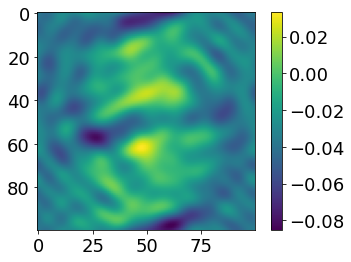

In [32]:
pahse = np.loadtxt('data/phase/100px/train_5.csv')
pahse = np.where(pahse > 0.5 , 1, -1) * 2.1 * np.pi / 180
model.layers[2].set_weights([pahse])
pred = model.predict(np.ones([1,100,100]))
plt.imshow(pred[0,:,:])
plt.colorbar()

2022-03-29 13:02:41.798411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


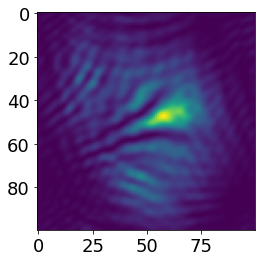

In [83]:
pred = model.predict(test_data['7'])
plt.imshow(pred[8,:,:])
# plt.colorbar()

In [9]:
eps = tf.constant([[1,0],[0,1]])
E = tf.constant([1,2], shape=(2,1))
out = tf.matmul(eps, E)

array([[1],
       [2]], dtype=int32)

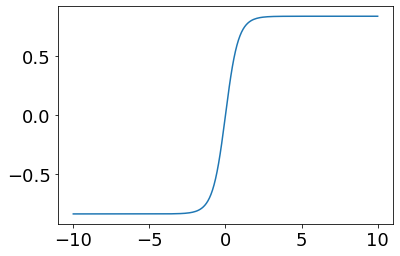

In [15]:
x = np.linspace(-10, 10, 200)

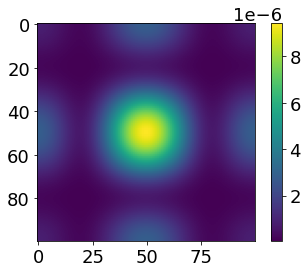

In [103]:
width = 100
height = 100
d = 1.0e-6
z = 5.0e-3
wavelength = 531e-9
image = cv2.resize(test_data['7'][8,:,:], (width, height))
image = np.where(image >= 0.5, 1.0, 0.0)
image = np.zeros_like(image)
image[49:51,49:51]=1.0
k = 2 * np.pi / wavelength
G = np.fft.fft2(image)
u = np.fft.fftfreq(width, d=d)
v = np.fft.fftfreq(height, d=d)
UU, VV = np.meshgrid(u, v)
w = np.where(UU**2 + VV**2 <= 1/(wavelength**2), tf.sqrt(1/(wavelength**2) - UU**2 - VV**2), 0).astype('float64')
# h = 2*np.pi / (1.0j * k * z)  * np.exp(1.0j * 2 * np.pi * w * z)
h = np.exp(1.0j * 2 * np.pi * w * z)

du = 1/(width * d)
dv = 1/(height * d)
u_limit = 1/(np.sqrt((2 * du * z)**2 + 1)) / wavelength
v_limit = 1/(np.sqrt((2 * dv * z)**2 + 1)) / wavelength
u_filter = np.where(np.abs(UU)/(2*u_limit) <= 1/2, 1, 0)
v_filter = np.where(np.abs(VV)/(2*v_limit) <= 1/2, 1, 0)
h = h * u_filter * v_filter
gz = np.fft.ifft2(G * h)
intens = gz * gz.conjugate()
intens
plt.imshow(intens.real)
plt.colorbar()

In [108]:
a = tf.complex(2.0, 4.0)
b = a * tf.math.conj(a)
b.real

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'real'

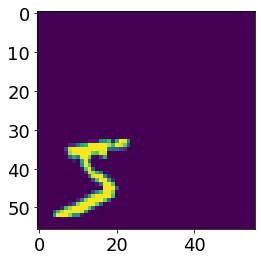

In [65]:
padded = np.pad(x_train[0,:,:],[[28, 0],[0,28]])
plt.imshow(padded)

In [15]:
x = tf.constant(np.pi)
y = tf.exp(x.numpy() * 1.0j)
phi_rcp = tf.complex(tf.cos(-x), tf.sin(-x))
phi_lcp = tf.complex(tf.cos(x), tf.sin(x))
print(y, phi_lcp, phi_rcp)

tf.Tensor((-0.9999999999999962-8.742278000372475e-08j), shape=(), dtype=complex128) tf.Tensor((-1-8.742278e-08j), shape=(), dtype=complex64) tf.Tensor((-1+8.742278e-08j), shape=(), dtype=complex64)
